<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# %pip install tf_keras pandas scipy tqdm scikit-learn matplotlib

Once the celd finished click on restart sesion.

In [17]:
output_dir = 'results'
run_date = '2024-dec-14'
dropout = 0.05

!mkdir {output_dir}
!mkdir {output_dir}/{run_date}
!mkdir {output_dir}/{run_date}/dp{dropout}
output_dir = f'{output_dir}/{run_date}/dp{dropout}'


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'results': File exists
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'results/2024-dec-14': File exists
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
mkdir: cannot create directory 'results/2024-dec-14/dp0.05': File exists


In [18]:
dropout

0.05

In [19]:
# %rm -rf experiments
# %rm -rf src
# %rm -rf lhcb-rich-gan-uncertainty-conare/
# !git clone https://gitlab.com/evillag/lhcb-rich-gan-uncertainty-conare.git
# !mv lhcb-rich-gan-uncertainty-conare/experiments .
# !mv lhcb-rich-gan-uncertainty-conare/src .
# %rm -rf lhcb-rich-gan-uncertainty-conare/
# %rm -rf sample_data/

In [20]:
# dataset downloading and extraction
# !wget --show-progress -O rich.zip https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx&st=1s4wciep&dl=0
# !unzip -qq rich.zip
# !rm rich.zip

# # checkpoints2
# !wget --show-progress -O checkpoints.zip https://www.dropbox.com/scl/fi/466pwb9aoizlxdrcwmu2p/checkpoints_dropout_0.01.zip?rlkey=eqx2c82md4qber0nilii3drq4&st=6m5qqjgg&dl=0
# !unzip -qq checkpoints.zip
# !rm checkpoints.zip
# 
# # embeddings
# !wget --show-progress -O embeddings.zip https://www.dropbox.com/scl/fi/qjwk4u5i55603zwubqbjw/embeddings.zip?rlkey=7ucyd46sa11nplaen0qz47cd4&st=8upo51x9&dl=0
# !unzip -qq embeddings.zip
# !rm embeddings.zip


# Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model
from feature_densities.feature_density_evaluator import create_embeddings_model
from feature_densities.feature_density_evaluator import get_histogram
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel
from tqdm import trange

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Instruct tf to use the GPU memory efficiently
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

## Experiment Params

In [22]:
# Parameters
PARTICLE = 'pion'
MCD_DP = dropout
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'data/rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLK', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# Experiment repetitions
N = 30

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load previous results (Optional)

Uncomment to load previous execution results.

In [23]:
# output_dir = f'/content/drive/MyDrive/cern/data/results/'

# x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
# y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
# t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

# mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
# fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
# #fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [24]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	data/rich/pion2_+_down_2016_.csv
	data/rich/pion2_+_up_2016_.csv
	data/rich/pion2_-_down_2016_.csv
	data/rich/pion2_-_up_2016_.csv
	data/rich/pion_+_down_2016_.csv
	data/rich/pion_+_up_2016_.csv
	data/rich/pion_-_down_2016_.csv
	data/rich/pion_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.4910120964050293
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948325, 3)
targets_train shape	(948325, 5)
feats_val shape  	(527302, 3)
targets_val shape	(527302, 5)
feats_train_orig shape	(948325, 3)
targets_train_orig shape	(948325, 5)
feats_val_orig shape  	(527302, 3)
targets_val_orig shape	(527302, 5)



In [25]:
# Draw a sample of the datasets
x_sample, y_sample, x_sample_orig, y_sample_orig = subsample_dataset(dataset['feats_val'], dataset['targets_val'], dataset['feats_val_orig'],  dataset['targets_val_orig'] , SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape,  x_sample_orig.shape, y_sample_orig.shape

(TensorShape([100000, 3]),
 TensorShape([100000, 5]),
 TensorShape([100000, 3]),
 TensorShape([100000, 5]))

# Model creation

In [26]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=MCD_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.05
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model_1"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0_Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0_LeakyReLU (LeakyReLU)             (None, 128)                           0 

## Single model prediction (Warmup)

In [27]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 10s 3ms/step


(100000, 5)

In [28]:
# Save real and generated targets
np.save(f'{output_dir}/{PARTICLE}_x_real.npy', x_sample)
np.save(f'{output_dir}/{PARTICLE}_y_real.npy', y_sample)
np.save(f'{output_dir}/{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

/tmp/ipykernel_137370/3963364024.py:14: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
/tmp/ipykernel_137370/3963364024.py:15: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')


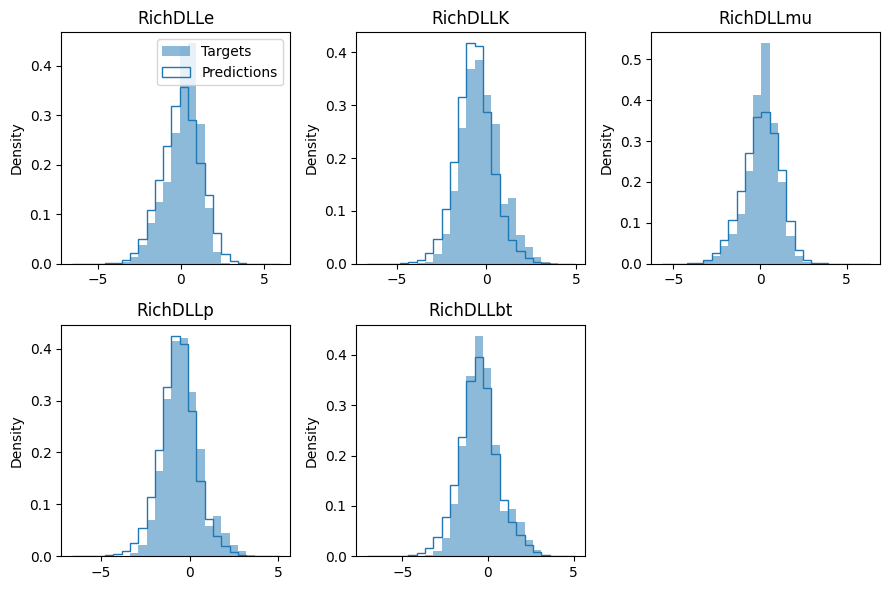

In [29]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [30]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress, kstest

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'quantiles',
                                                 particle_index = 0, metric = 'JS', n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 3)

  distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_title(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{dll_columns[particle_index]}')


    if metric == 'JS':
      dist = jensenshannon(predictions_hist, targets_hist)
    else:
      dist = kstest(predictions[indices], targets[indices]).statistic

    distances += [dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_uncertainty_score_bins_for_{dll_columns[particle_index]}.tex')
  except:
    plt.show()
  print(f"{metric} Distances:\n" + ", ".join([str(dist) for dist in distances]))

  return bin_edges, distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0, metric='JS'):
  plt.figure()
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  correlation_coefficient = []
  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    correlation_coefficient += [regress.rvalue]
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  if metric == 'JS':
    plt.ylabel('Jensen–Shannon distance')
  else:
    plt.ylabel('Kolmogorov-Smirnov distance')
  plt.legend()

  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_reliability_curves_{metric}.tex')
  except:
    plt.show()


## Monte Carlo Dropout method

## Uncertainty estimation

In [31]:
def mcd_uncertainties_experiment(repetitions=N, mode='ensemble_inference'):
  # MCD ensemble mode
  mcd_ensemble_uncertainties = []
  mcd_duration = []

  for i in trange(repetitions):
    # print(f'MCD ensemble mode Run {i + 1} of {repetitions}')
    start_time = time.time()
    mcd_unc = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE, mode=mode)[0]
    end_time = time.time()    
    mcd_ensemble_uncertainties.append(mcd_unc)
    mcd_duration.append(end_time - start_time)
    # print(f"Elapsed time: {mcd_duration[-1]} seconds")

  stacked_mcd_ensemble = tf.stack(mcd_ensemble_uncertainties)
  average_mcd_ensemble = tf.reduce_mean(stacked_mcd_ensemble, axis=0)

  return average_mcd_ensemble, stacked_mcd_ensemble, mcd_duration

def mcd_global_experiment(global_repetitions=N):
  mcd_all_uncertainties = []
  mcd_all_durations = []
  
  for i in range(global_repetitions):
    print(f'MCD Experiment Run {i + 1} of {global_repetitions}')
    average_mcd_ensemble, _, mcd_durations = mcd_uncertainties_experiment()
    average_mcd_single, _, _ = mcd_uncertainties_experiment(mode='single')

    mcd_final_uncertainty = np.abs(average_mcd_ensemble - average_mcd_single)    
    mcd_all_uncertainties.append(mcd_final_uncertainty)
    mcd_all_durations.append(mcd_durations)

  return mcd_all_uncertainties, mcd_all_durations


In [32]:
mcd_all_uncertainties, mcd_all_durations = mcd_global_experiment(N)
mcd_final_uncertainty = tf.reduce_mean(mcd_all_uncertainties, axis=0)

MCD Experiment Run 1 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 2 of 30


100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


MCD Experiment Run 3 of 30


100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


MCD Experiment Run 4 of 30


100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


MCD Experiment Run 5 of 30


100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


MCD Experiment Run 6 of 30


100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


MCD Experiment Run 7 of 30


100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


MCD Experiment Run 8 of 30


100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


MCD Experiment Run 9 of 30


100%|██████████| 30/30 [00:57<00:00,  1.91s/it]


MCD Experiment Run 10 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 11 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 12 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 13 of 30


100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


MCD Experiment Run 14 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 15 of 30


100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


MCD Experiment Run 16 of 30


100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


MCD Experiment Run 17 of 30


100%|██████████| 30/30 [00:53<00:00,  1.80s/it]


MCD Experiment Run 18 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 19 of 30


100%|██████████| 30/30 [00:57<00:00,  1.90s/it]


MCD Experiment Run 20 of 30


100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


MCD Experiment Run 21 of 30


100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


MCD Experiment Run 22 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 23 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 24 of 30


100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


MCD Experiment Run 25 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 26 of 30


100%|██████████| 30/30 [00:56<00:00,  1.90s/it]


MCD Experiment Run 27 of 30


100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


MCD Experiment Run 28 of 30


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


MCD Experiment Run 29 of 30


100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


MCD Experiment Run 30 of 30


100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


In [33]:
# Save MCD duration
mcd_avg_duration = np.mean(mcd_all_durations)
mcd_std_duration = np.std(mcd_all_durations)
print(f"MCD Average duration:\t{mcd_avg_duration} seconds")
print(f"MCD Std duration:\t\t{mcd_std_duration} seconds")
np.save(f'{output_dir}/{PARTICLE}_mcd_duration_list.npy', mcd_all_durations)

# Save MCD uncertainties
np.save(f'{output_dir}/{PARTICLE}_mcd_uncertainty.npy', mcd_all_uncertainties)


MCD Average duration:	4.944443554348416 seconds
MCD Std duration:		1.0213261204967397 seconds


In [34]:
print(mcd_all_durations)
print(len(mcd_all_uncertainties))
print(len(mcd_all_uncertainties[0]))
print(mcd_final_uncertainty.shape)

[[2.9618313312530518, 5.4542670249938965, 5.574265241622925, 5.491401433944702, 5.4040398597717285, 5.519751310348511, 2.6614327430725098, 5.20544695854187, 5.376585483551025, 5.172842979431152, 5.2691872119903564, 5.273187637329102, 2.4797351360321045, 5.1869423389434814, 5.1611034870147705, 5.200759649276733, 5.272110462188721, 5.2453789710998535, 2.292196750640869, 5.265117168426514, 5.157797574996948, 5.305357456207275, 5.295229434967041, 5.2810890674591064, 2.4651176929473877, 5.244980812072754, 5.229189395904541, 5.3472349643707275, 5.2679948806762695, 5.112580299377441], [5.344994068145752, 5.21773624420166, 2.508939266204834, 5.257886648178101, 5.204624891281128, 5.1741626262664795, 5.231244802474976, 5.217108488082886, 5.229944229125977, 2.2221500873565674, 5.246860980987549, 5.248985290527344, 5.264035701751709, 5.272252798080444, 5.249702215194702, 2.504793643951416, 5.39751672744751, 5.727831840515137, 5.849458694458008, 5.740952491760254, 5.606596946716309, 2.8037607669830

### Plot MCD uncertainties

#### JS / Quantile bins

0.079 < unc. score < 0.115: Number of observations: 10000
0.115 < unc. score < 0.13: Number of observations: 10000
0.13 < unc. score < 0.145: Number of observations: 10000
0.145 < unc. score < 0.159: Number of observations: 10000
0.159 < unc. score < 0.176: Number of observations: 10000
0.176 < unc. score < 0.195: Number of observations: 10000
0.195 < unc. score < 0.219: Number of observations: 10000


/tmp/ipykernel_137370/130207876.py:37: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
/tmp/ipykernel_137370/130207876.py:38: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.219 < unc. score < 0.252: Number of observations: 10000
0.252 < unc. score < 0.304: Number of observations: 10000
0.304 < unc. score < 0.972: Number of observations: 9999


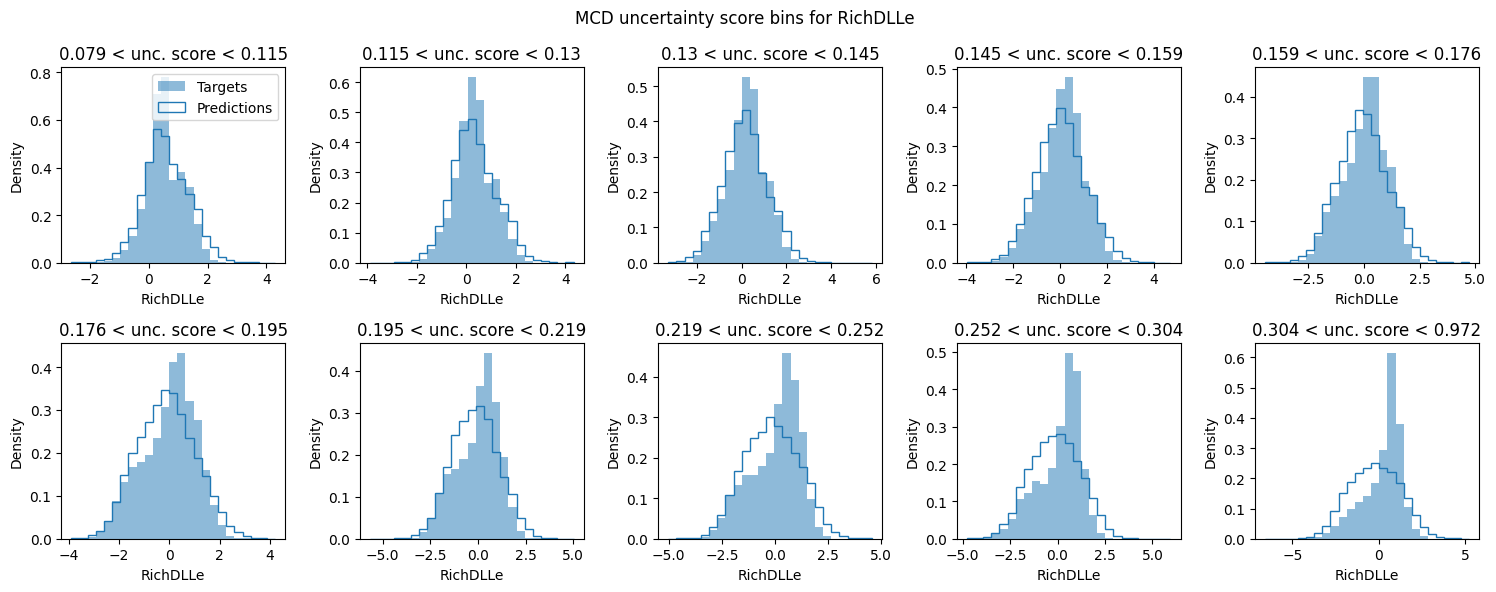

JS Distances:
0.1289086143637159, 0.11296888098345784, 0.10157948739459524, 0.1023939994261872, 0.11419007108067018, 0.11402168015230794, 0.13600884846723837, 0.16882547099624934, 0.18963088909958756, 0.24398559350101057
0.008 < unc. score < 0.105: Number of observations: 10000
0.105 < unc. score < 0.135: Number of observations: 10000
0.135 < unc. score < 0.165: Number of observations: 10000
0.165 < unc. score < 0.198: Number of observations: 10000
0.198 < unc. score < 0.236: Number of observations: 10000
0.236 < unc. score < 0.282: Number of observations: 10000
0.282 < unc. score < 0.339: Number of observations: 10000
0.339 < unc. score < 0.416: Number of observations: 10000
0.416 < unc. score < 0.552: Number of observations: 10000
0.552 < unc. score < 2.044: Number of observations: 9999


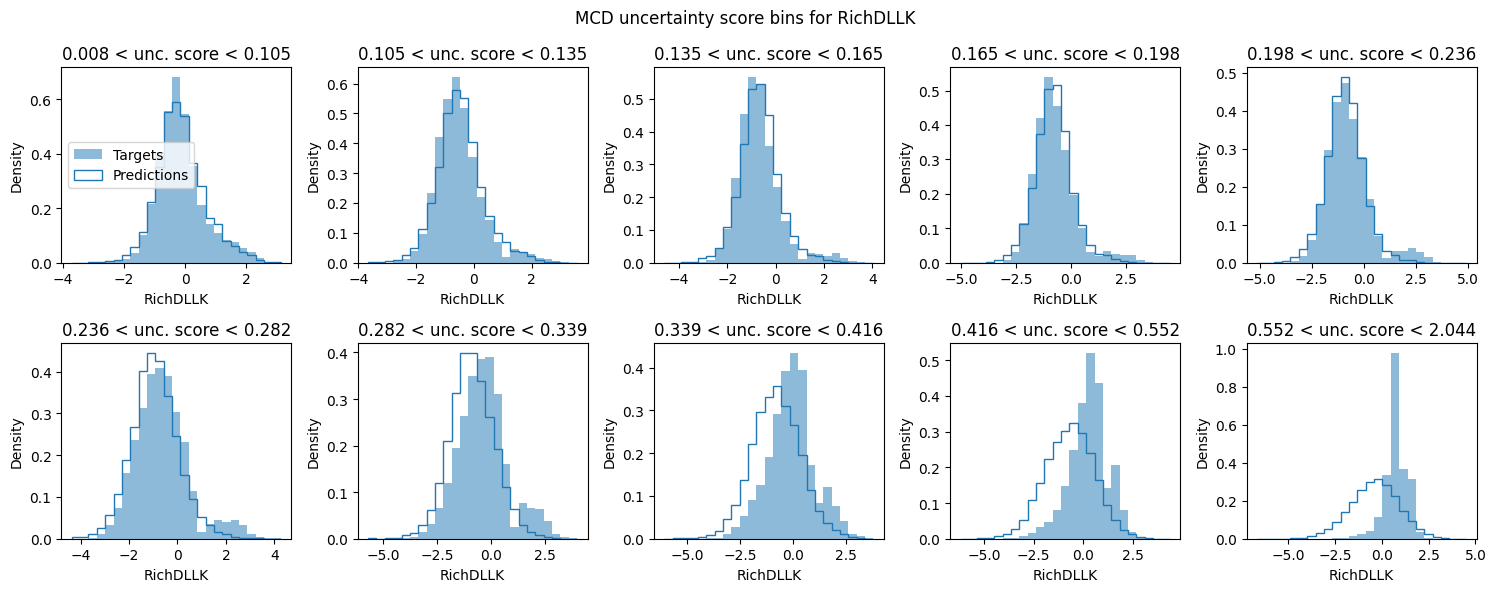

JS Distances:
0.06306798255129203, 0.08123132277957068, 0.10534580040148453, 0.10160525975692127, 0.11249620964663411, 0.1372343866838254, 0.1918841079352379, 0.23016190546601345, 0.3142018905329618, 0.45958047364996607
0.058 < unc. score < 0.084: Number of observations: 10000
0.084 < unc. score < 0.099: Number of observations: 10000
0.099 < unc. score < 0.114: Number of observations: 10000
0.114 < unc. score < 0.128: Number of observations: 10000
0.128 < unc. score < 0.143: Number of observations: 10000
0.143 < unc. score < 0.16: Number of observations: 10000
0.16 < unc. score < 0.18: Number of observations: 10000
0.18 < unc. score < 0.207: Number of observations: 10000
0.207 < unc. score < 0.25: Number of observations: 10000
0.25 < unc. score < 0.722: Number of observations: 9999


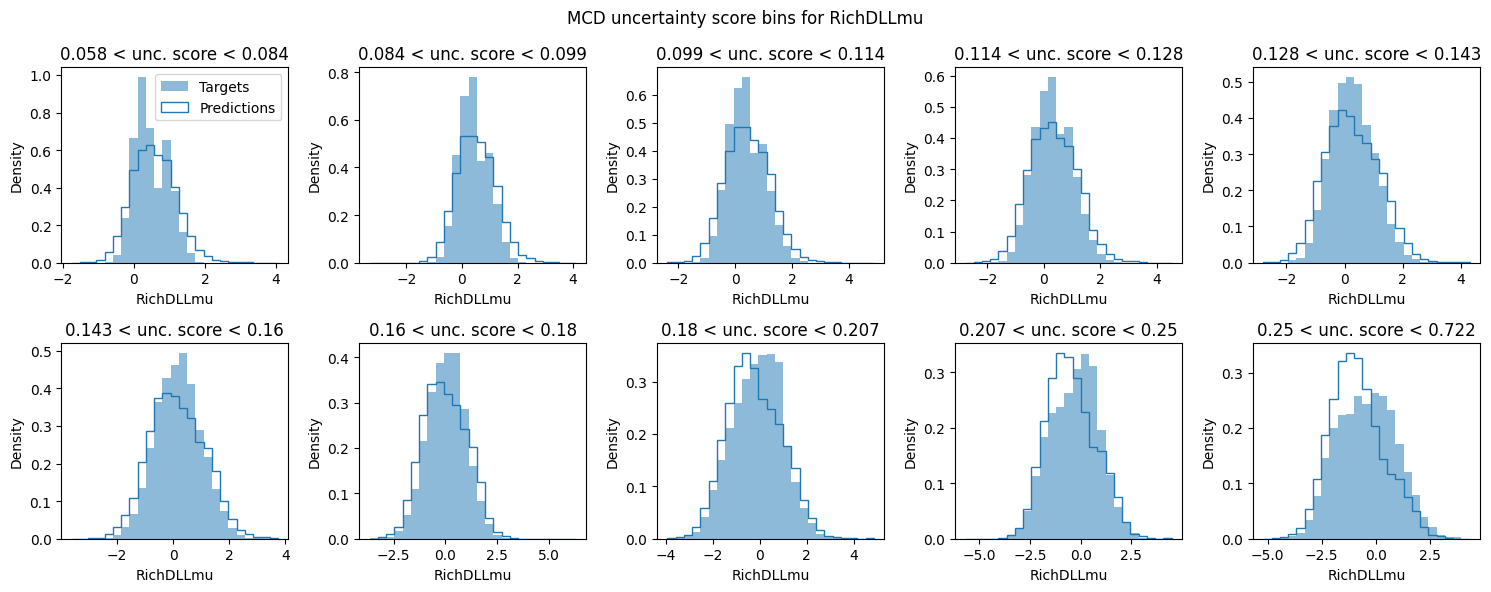

JS Distances:
0.17973596449732002, 0.14913154099535564, 0.12721057852805825, 0.11837166807794519, 0.12178613236315675, 0.10539651527717739, 0.09614307099440948, 0.09332899644515863, 0.1065039880235011, 0.1403310930922877
0.007 < unc. score < 0.106: Number of observations: 10000
0.106 < unc. score < 0.132: Number of observations: 10000
0.132 < unc. score < 0.156: Number of observations: 10000
0.156 < unc. score < 0.181: Number of observations: 10000
0.181 < unc. score < 0.208: Number of observations: 10000
0.208 < unc. score < 0.241: Number of observations: 10000
0.241 < unc. score < 0.282: Number of observations: 10000
0.282 < unc. score < 0.34: Number of observations: 10000
0.34 < unc. score < 0.436: Number of observations: 10000
0.436 < unc. score < 1.742: Number of observations: 9999


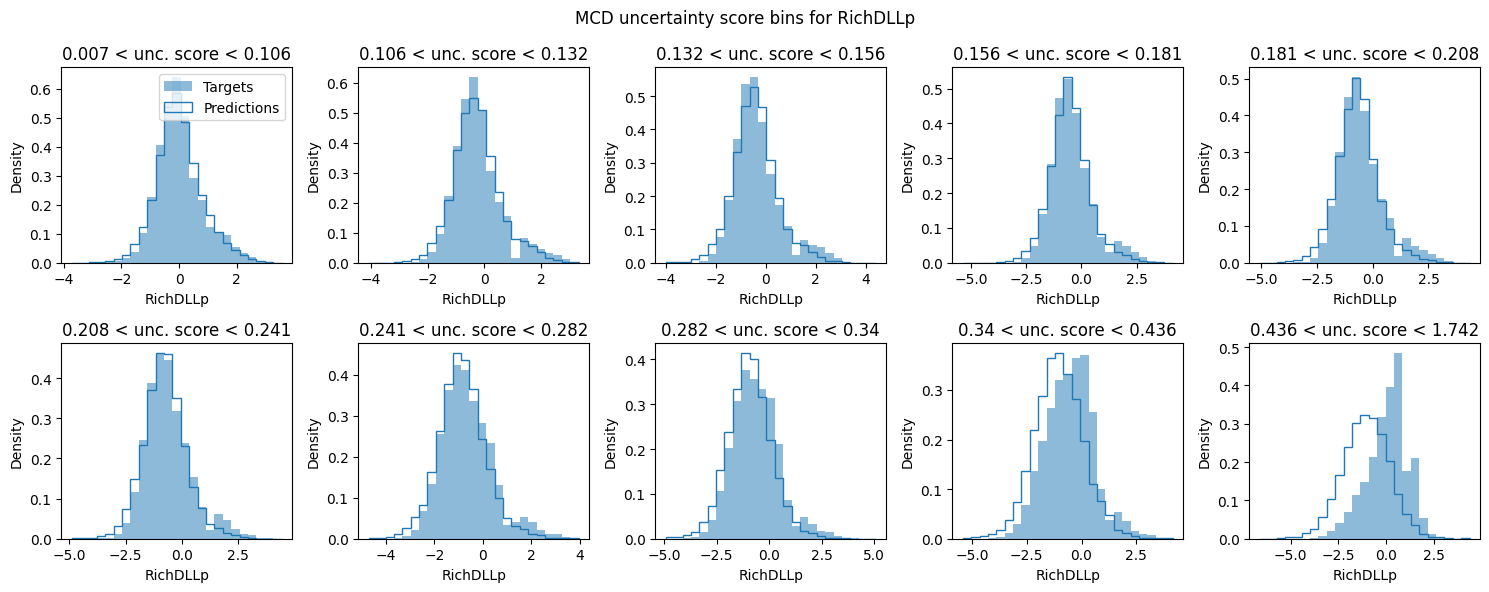

JS Distances:
0.06277549002913708, 0.09232427769261474, 0.10003660528833908, 0.08989728581589211, 0.10813029765092853, 0.09857618331346571, 0.10651527780052053, 0.11982360116527122, 0.17461025634662425, 0.3391869901644246
0.007 < unc. score < 0.114: Number of observations: 10000
0.114 < unc. score < 0.146: Number of observations: 10000
0.146 < unc. score < 0.175: Number of observations: 10000
0.175 < unc. score < 0.206: Number of observations: 10000
0.206 < unc. score < 0.239: Number of observations: 10000
0.239 < unc. score < 0.279: Number of observations: 10000
0.279 < unc. score < 0.329: Number of observations: 10000
0.329 < unc. score < 0.398: Number of observations: 10000
0.398 < unc. score < 0.508: Number of observations: 10000
0.508 < unc. score < 2.066: Number of observations: 9999


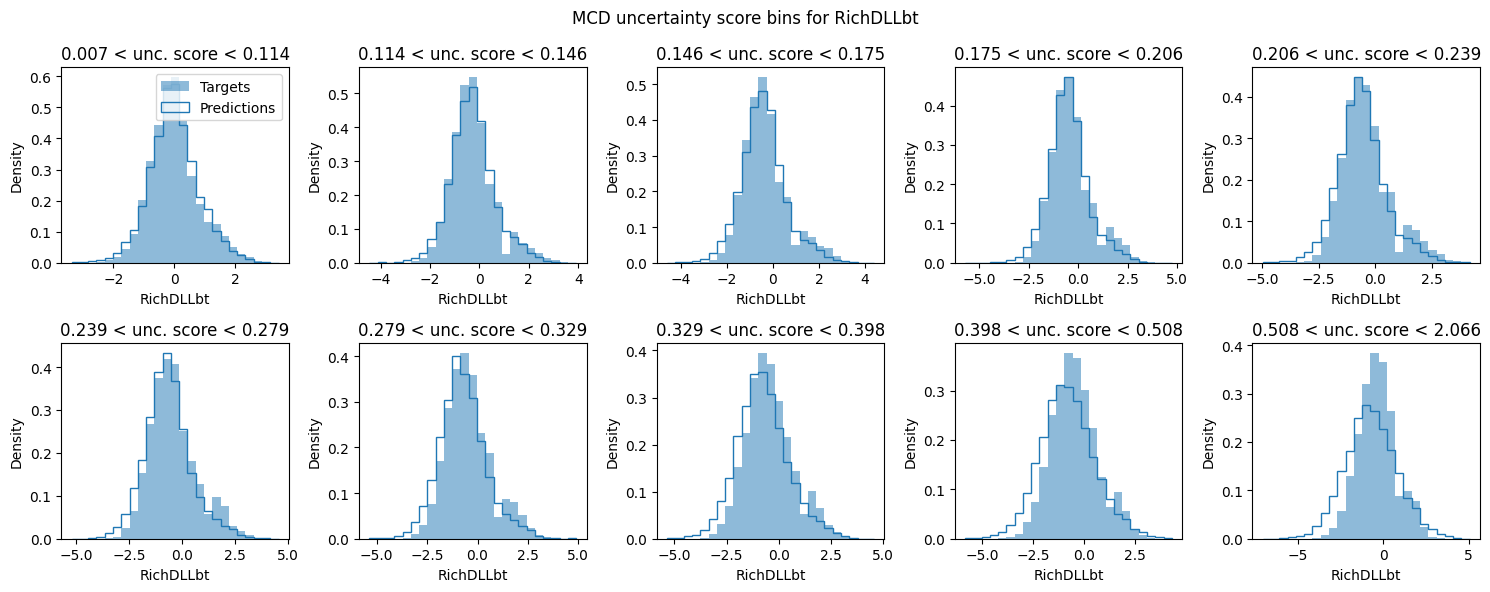

JS Distances:
0.05504483967102007, 0.08671251502090284, 0.08990583569758914, 0.09454389703083431, 0.11395120228374106, 0.10770851354699253, 0.12090204925257546, 0.13152604866606218, 0.1493112016044137, 0.1912025296787682


In [35]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.9080917723582955
Correlation coefficient for RichDLLK: 0.9497922990850143
Correlation coefficient for RichDLLmu: -0.12573370327674696
Correlation coefficient for RichDLLp: 0.988974663474682
Correlation coefficient for RichDLLbt: 0.9009521418277081


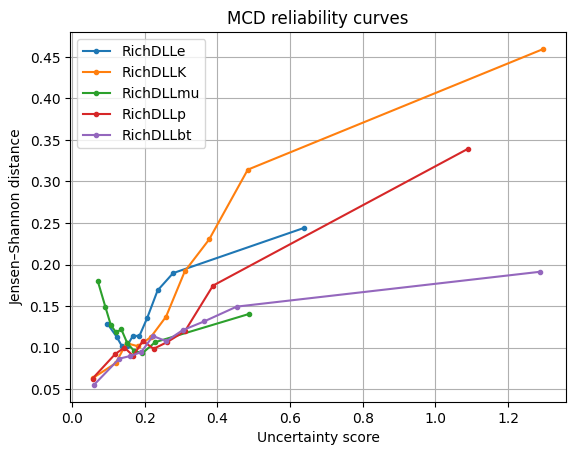

In [36]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

#### KS / Quantile bins

0.079 < unc. score < 0.115: Number of observations: 10000


/tmp/ipykernel_137370/130207876.py:37: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
/tmp/ipykernel_137370/130207876.py:38: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  predictions_hist = ax.hist(


0.115 < unc. score < 0.13: Number of observations: 10000
0.13 < unc. score < 0.145: Number of observations: 10000
0.145 < unc. score < 0.159: Number of observations: 10000
0.159 < unc. score < 0.176: Number of observations: 10000
0.176 < unc. score < 0.195: Number of observations: 10000
0.195 < unc. score < 0.219: Number of observations: 10000
0.219 < unc. score < 0.252: Number of observations: 10000
0.252 < unc. score < 0.304: Number of observations: 10000
0.304 < unc. score < 0.972: Number of observations: 9999


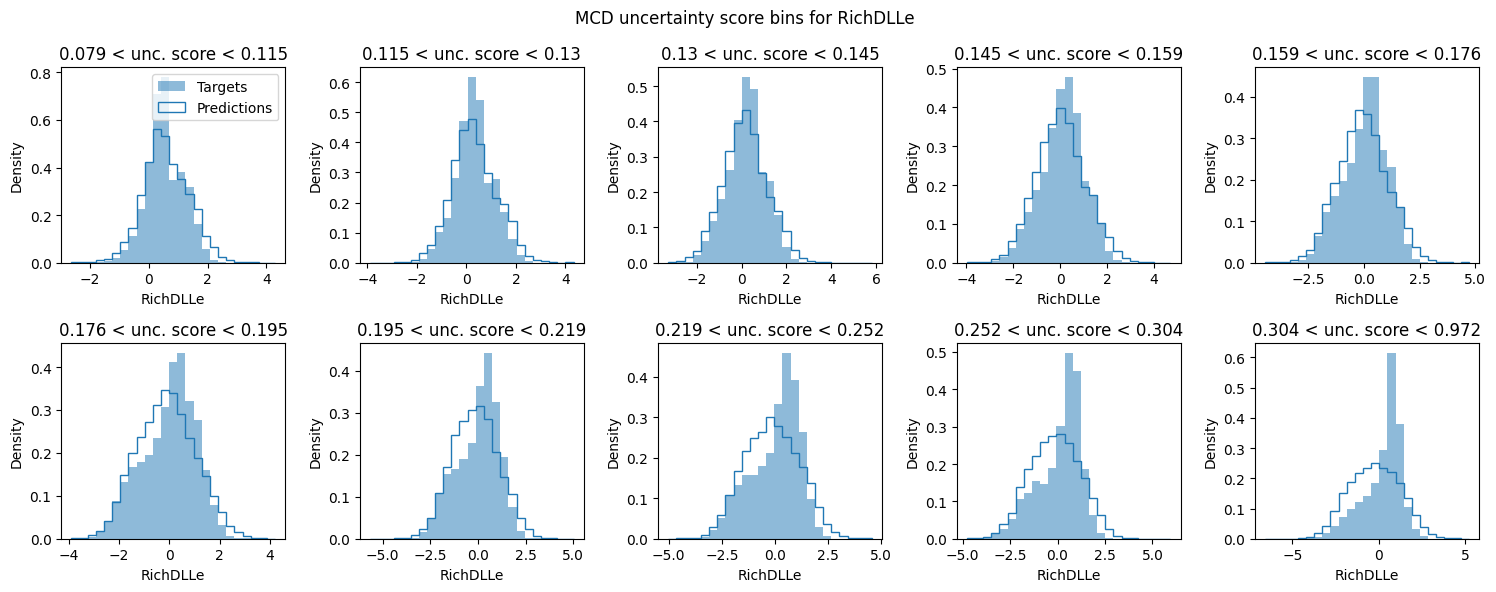

KS Distances:
0.0741, 0.0633, 0.067, 0.0797, 0.0953, 0.103, 0.1249, 0.1485, 0.1797, 0.24422442244224424
0.008 < unc. score < 0.105: Number of observations: 10000
0.105 < unc. score < 0.135: Number of observations: 10000
0.135 < unc. score < 0.165: Number of observations: 10000
0.165 < unc. score < 0.198: Number of observations: 10000
0.198 < unc. score < 0.236: Number of observations: 10000
0.236 < unc. score < 0.282: Number of observations: 10000
0.282 < unc. score < 0.339: Number of observations: 10000
0.339 < unc. score < 0.416: Number of observations: 10000
0.416 < unc. score < 0.552: Number of observations: 10000
0.552 < unc. score < 2.044: Number of observations: 9999


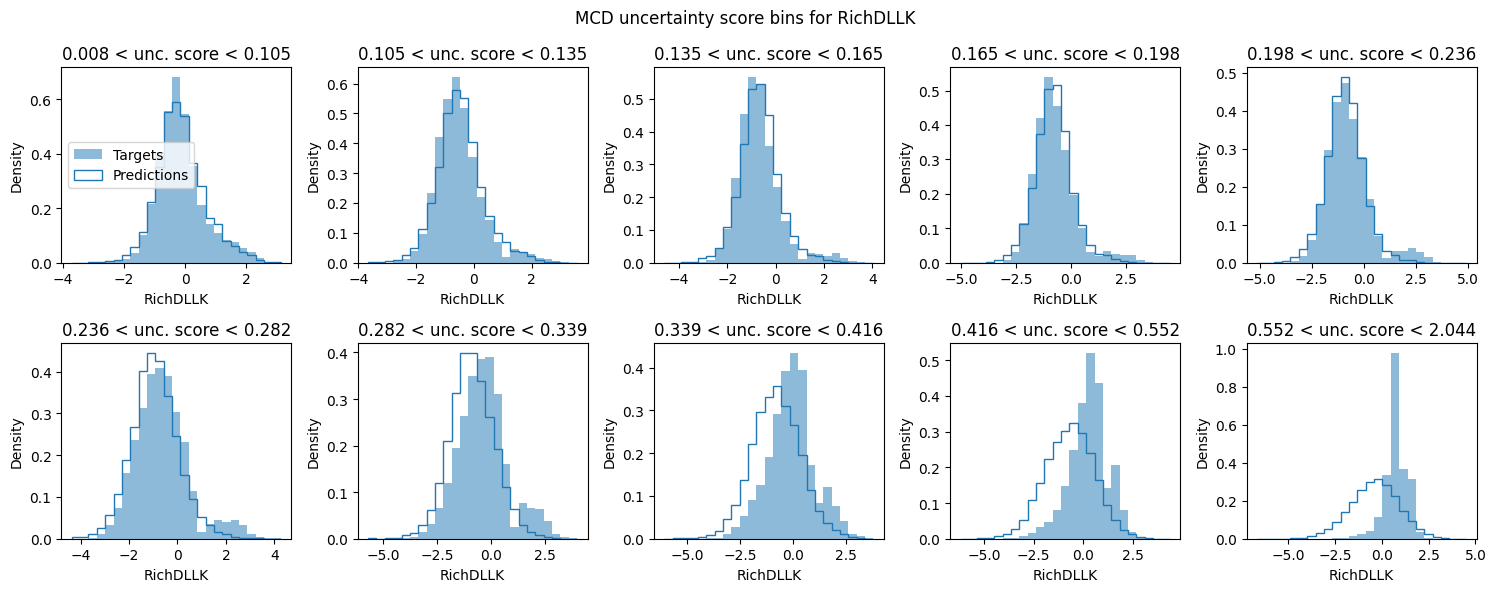

KS Distances:
0.0278, 0.0525, 0.057, 0.0337, 0.0453, 0.1114, 0.2005, 0.2825, 0.3814, 0.5480548054805481
0.058 < unc. score < 0.084: Number of observations: 10000
0.084 < unc. score < 0.099: Number of observations: 10000
0.099 < unc. score < 0.114: Number of observations: 10000
0.114 < unc. score < 0.128: Number of observations: 10000
0.128 < unc. score < 0.143: Number of observations: 10000
0.143 < unc. score < 0.16: Number of observations: 10000
0.16 < unc. score < 0.18: Number of observations: 10000
0.18 < unc. score < 0.207: Number of observations: 10000
0.207 < unc. score < 0.25: Number of observations: 10000
0.25 < unc. score < 0.722: Number of observations: 9999


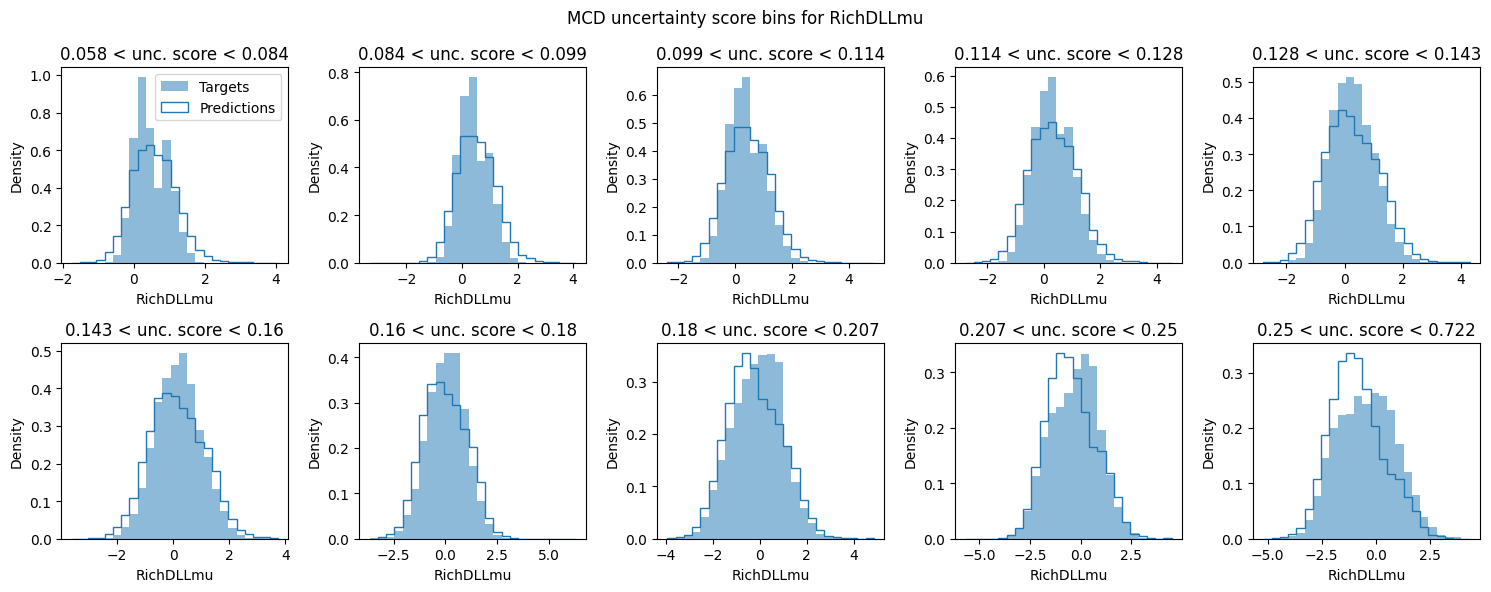

KS Distances:
0.1042, 0.1044, 0.0745, 0.0604, 0.0695, 0.072, 0.0773, 0.094, 0.123, 0.1787178717871787
0.007 < unc. score < 0.106: Number of observations: 10000
0.106 < unc. score < 0.132: Number of observations: 10000
0.132 < unc. score < 0.156: Number of observations: 10000
0.156 < unc. score < 0.181: Number of observations: 10000
0.181 < unc. score < 0.208: Number of observations: 10000
0.208 < unc. score < 0.241: Number of observations: 10000
0.241 < unc. score < 0.282: Number of observations: 10000
0.282 < unc. score < 0.34: Number of observations: 10000
0.34 < unc. score < 0.436: Number of observations: 10000
0.436 < unc. score < 1.742: Number of observations: 9999


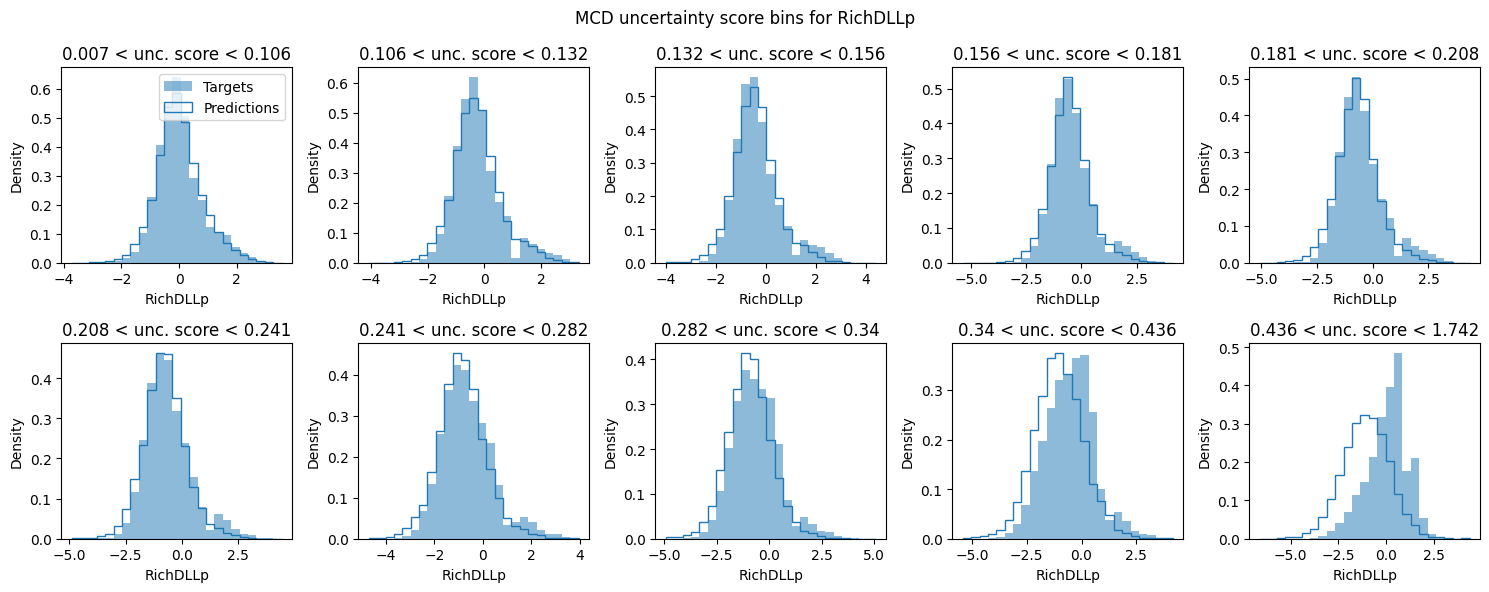

KS Distances:
0.024, 0.028, 0.0353, 0.037, 0.0449, 0.047, 0.08, 0.1173, 0.2011, 0.41844184418441843
0.007 < unc. score < 0.114: Number of observations: 10000
0.114 < unc. score < 0.146: Number of observations: 10000
0.146 < unc. score < 0.175: Number of observations: 10000
0.175 < unc. score < 0.206: Number of observations: 10000
0.206 < unc. score < 0.239: Number of observations: 10000
0.239 < unc. score < 0.279: Number of observations: 10000
0.279 < unc. score < 0.329: Number of observations: 10000
0.329 < unc. score < 0.398: Number of observations: 10000
0.398 < unc. score < 0.508: Number of observations: 10000
0.508 < unc. score < 2.066: Number of observations: 9999


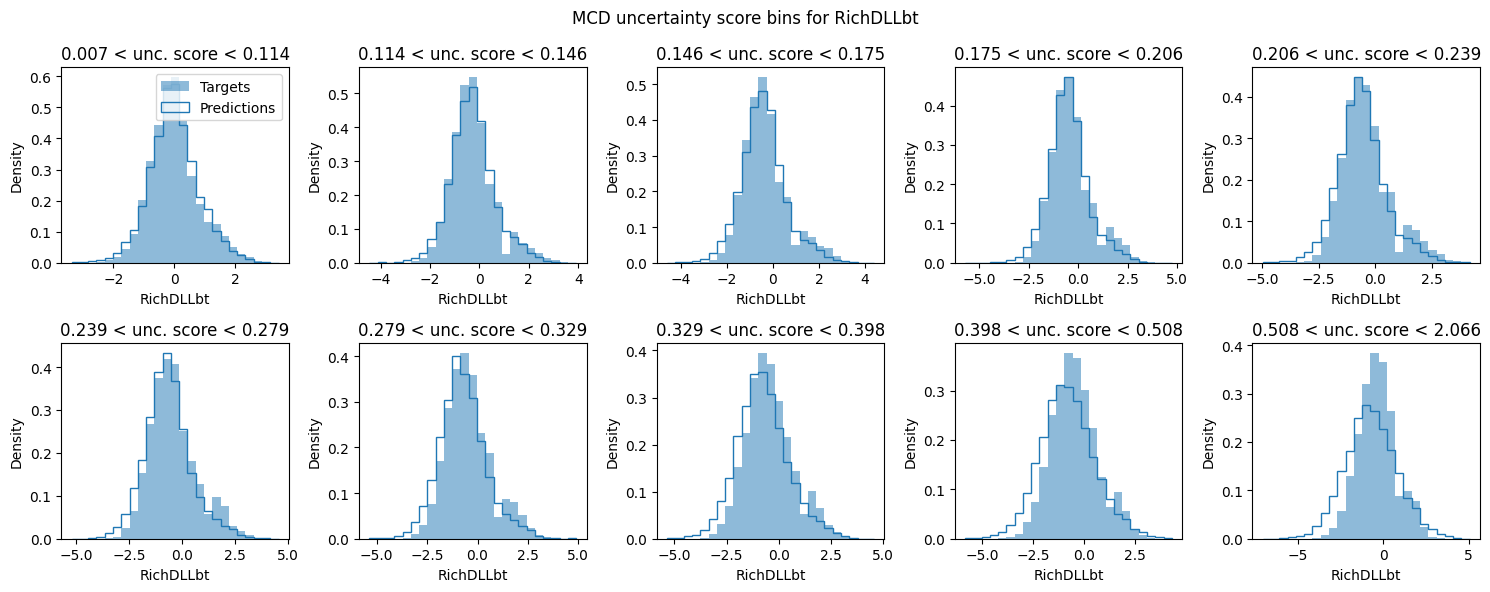

KS Distances:
0.021, 0.0262, 0.0391, 0.0474, 0.0611, 0.0891, 0.1014, 0.1261, 0.1374, 0.15981598159815982


In [37]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.9316331918787693
Correlation coefficient for RichDLLK: 0.9156116361388026
Correlation coefficient for RichDLLmu: 0.8162997713171166
Correlation coefficient for RichDLLp: 0.9798825929535216
Correlation coefficient for RichDLLbt: 0.7970219045905462


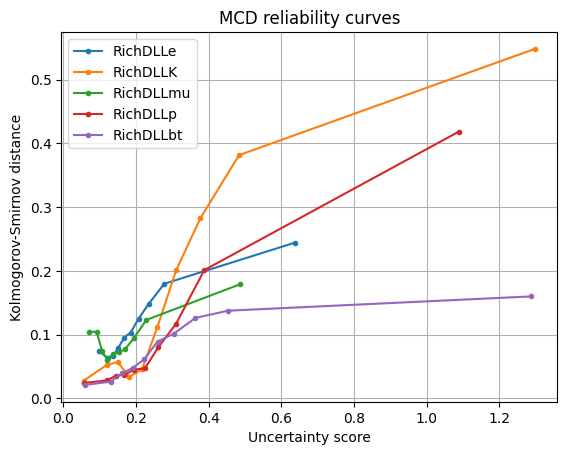

In [38]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

## Uncertainty heatmaps

### MCD heatmaps

In [39]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

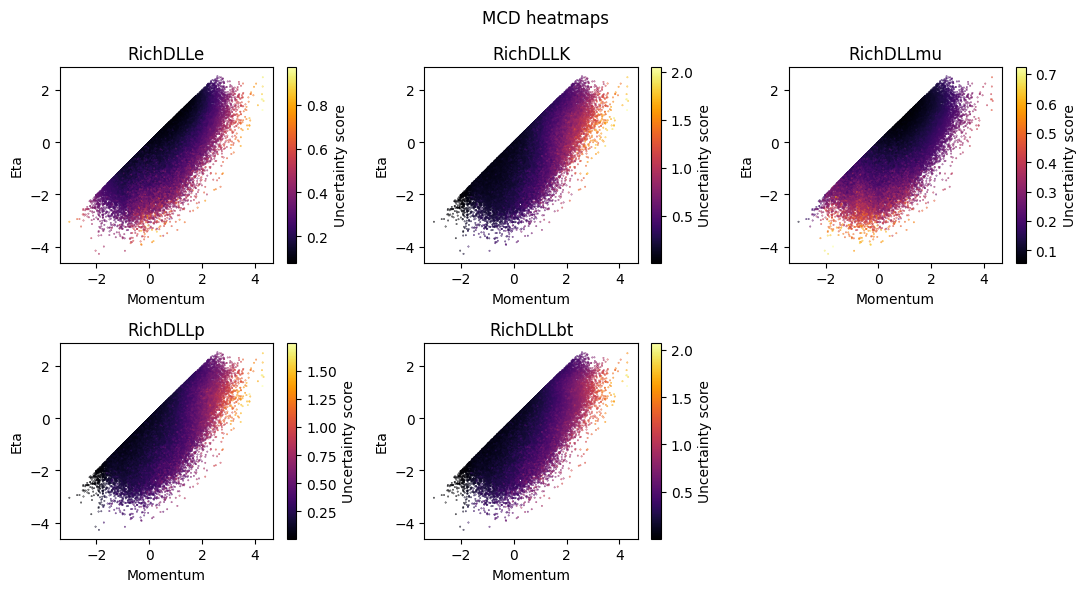

In [40]:
uncertainty_scatter_plot_mcd(x_sample, mcd_final_uncertainty)

In [41]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap, 'inferno')
    ax.invert_yaxis()
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_137370/2849941025.py:19: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
/home/esteban/.virtualenvs/cern/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


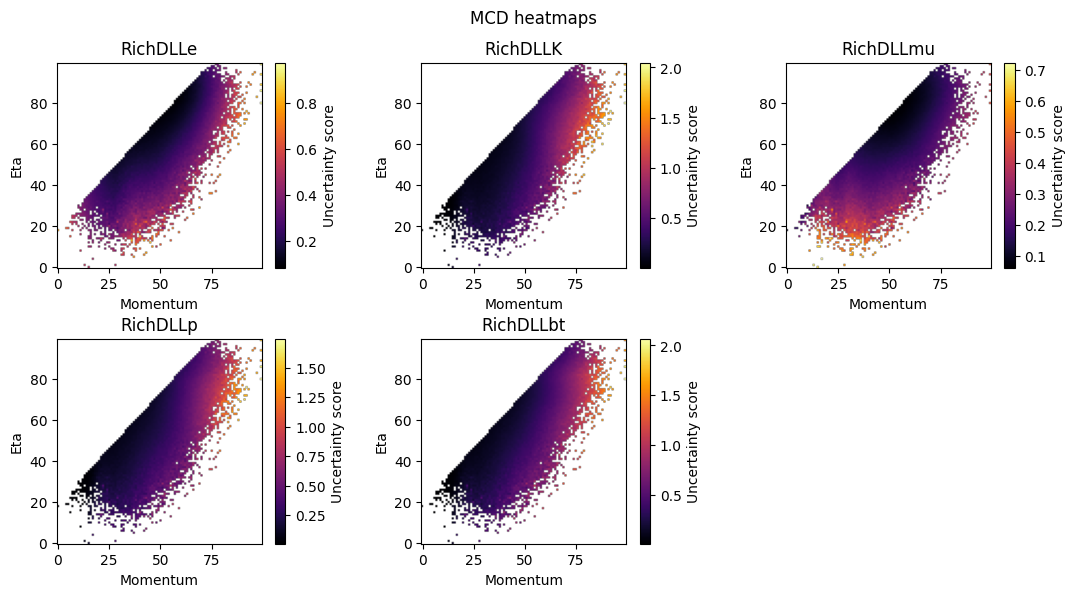

In [42]:
uncertainty_hist2d_mcd(x_sample, mcd_final_uncertainty)

In [43]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_mcd(x_real, uncertainties, particle_idx, n_bins=5, dll_columns=DLL_COLUMNS, bin_size=50):

    if not isinstance(x_real, np.ndarray):
      x_real = x_real.numpy()

    if not isinstance(uncertainties, np.ndarray):
      uncertainties = uncertainties.numpy()

    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True)

    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        ax = axes[i]

        bin_mask = bin_indices == (i + 1)
        x_data = momentum[bin_mask]
        y_data = eta[bin_mask]
        u_data = uncertainties[bin_mask, particle_idx]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno', shading='auto')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum(MeV/c)')
        ax.set_ylabel('Eta')

        plt.suptitle(f'MCD Heatmap for Different Track Ranges for particle {DLL_COLUMNS[particle_idx]}', y=1.05)

    fig.colorbar(mesh, ax=axes, label='Uncertainty score', orientation='vertical', fraction=0.02, pad=0.01)
    plt.savefig(f'MCD_Heatmap_for_Different_Track_Ranges_for_particle_{DLL_COLUMNS[particle_idx]}.svg', format="svg")
    plt.show()

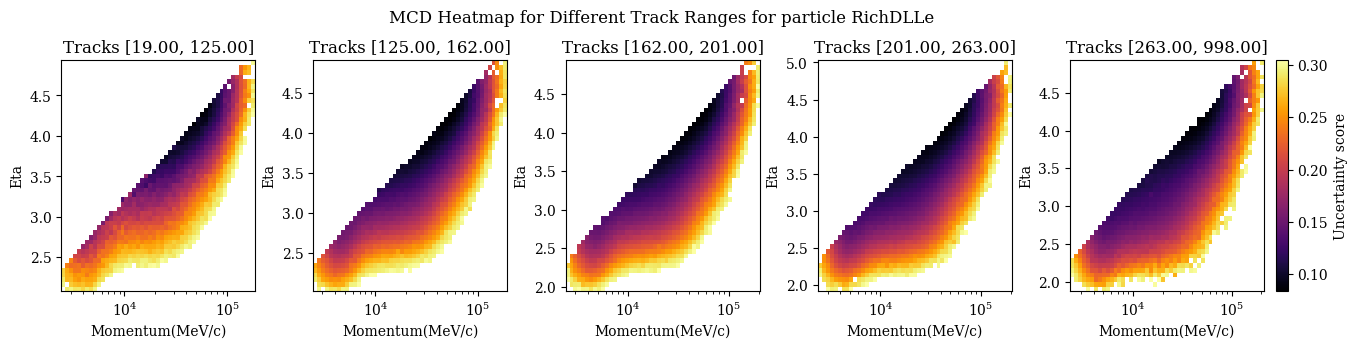

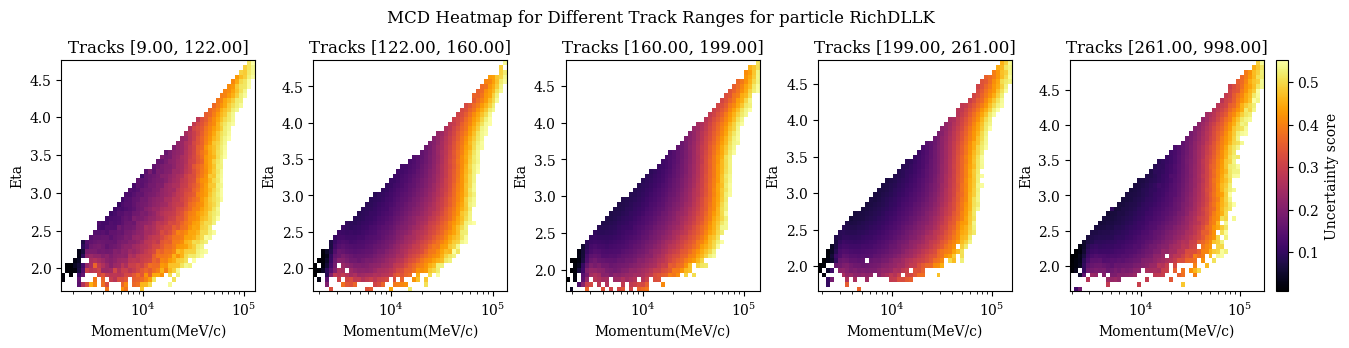

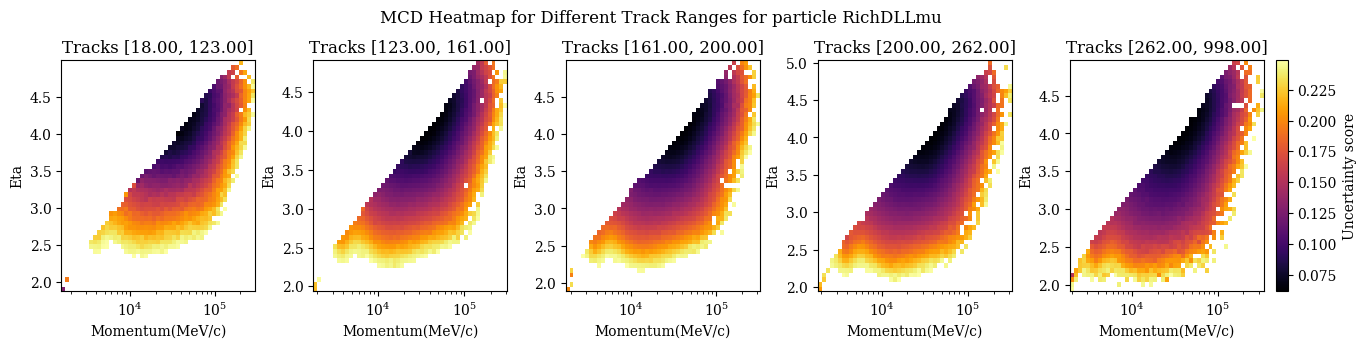

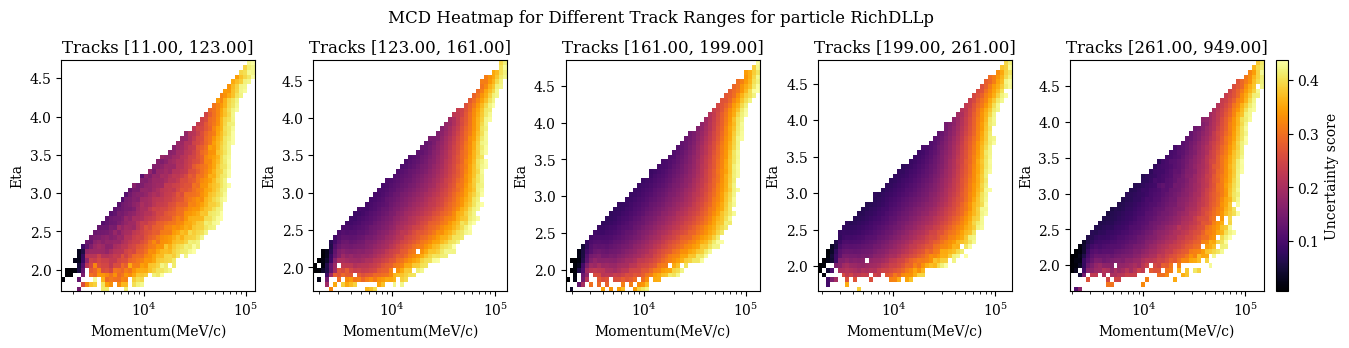

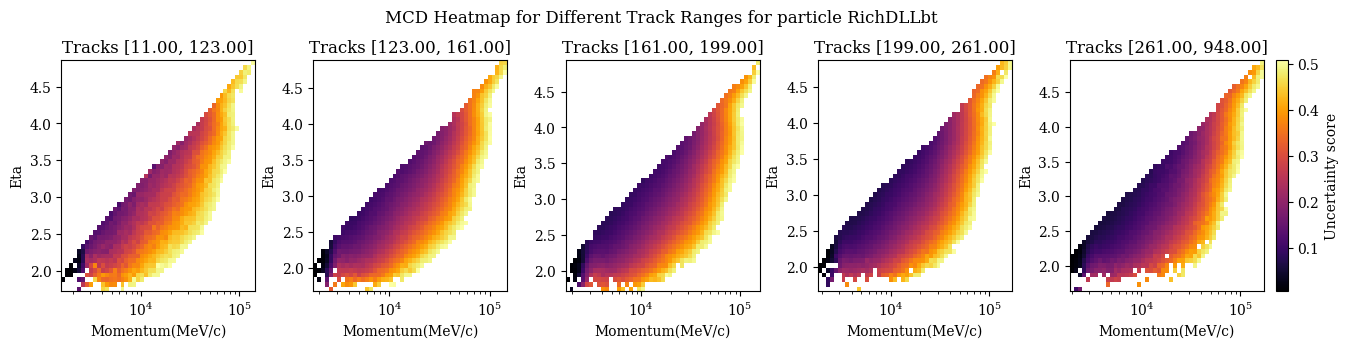

In [44]:
for i in range(5):
  uncertainty_scores = mcd_final_uncertainty[:, i]
  bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, 11))
  limit = bin_edges[9]

  reduced_x_sample = x_sample_orig[uncertainty_scores < limit]
  reduced_uncertainty = mcd_final_uncertainty[uncertainty_scores < limit]
  #print(reduced_x_sample.shape)
  #print(reduced_uncertainty.shape)
  uncertainty_binned2d_mcd(reduced_x_sample, reduced_uncertainty, i)

# Efficiency plots

In [45]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

## Plot Efficiencies by particle

In [46]:
def plot_efficiencies_by_particle(y_sample, t_generated, uncertainties, quantiles, uncertainty_type="MCD", particle_idx=0, n_bins=10, dll_columns=DLL_COLUMNS):
    y_sample = np.array(y_sample)
    t_generated = np.array(t_generated)
    uncertainties = np.array(uncertainties)

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    colors = plt.colormaps['tab10']

    if uncertainty_type == "MCD":
        uncertainties_column = uncertainties[:, particle_idx]
    else:
        uncertainties_column = uncertainties


    bin_edges = np.quantile(uncertainties_column, np.linspace(0, 1, n_bins + 1))
    indices = np.digitize(uncertainties_column, bin_edges, right=True)

    bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
    bins_real = [y_sample[indices == i] for i in range(1, n_bins + 1)]
    bins_likelihoods = [uncertainties_column[indices == i].mean() for i in range(1, n_bins + 1)]

    for idx, ax in zip(range(len(quantiles)), axes.flatten()):
        quantile = quantiles[idx]
        threshold = select_threshold(y_sample[:, particle_idx], quantile)

        eff_gen, err_gen = efficiency_bins(bins_targets, threshold, particle_idx)
        eff_real, err_real = efficiency_bins(bins_real, threshold, particle_idx)



        ax.plot(bins_likelihoods, eff_gen, '.-', color=colors(0), label='Generated')

        ax.fill_between(bins_likelihoods, np.array(eff_gen) - np.array(err_gen),
                        np.array(eff_gen) + np.array(err_gen), color=colors(0), alpha=0.3)

        ax.plot(bins_likelihoods, eff_real, '.-', color=colors(20), label='Real')

        ax.fill_between(bins_likelihoods, np.array(eff_real) - np.array(err_real),
                        np.array(eff_real) + np.array(err_real), color=colors(20), alpha=0.3)

        ax.set_title(f'Threshold {int(quantile * 100)}%')
        ax.set_axisbelow(True)
        ax.grid()
        ax.set_xlabel("Uncertainty Score")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1.10)

    axes[-1, -1].axis(False)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize='small')

    plt.suptitle(f'{uncertainty_type} efficiencies plot for {dll_columns[particle_idx]}')

    plt.tight_layout()
    plt.show()

### Plot MCD efficiencies

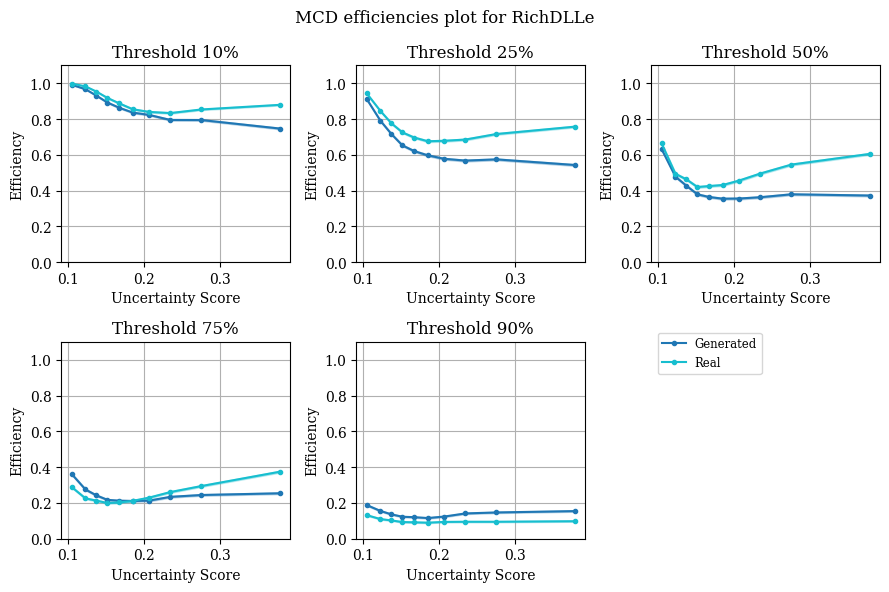

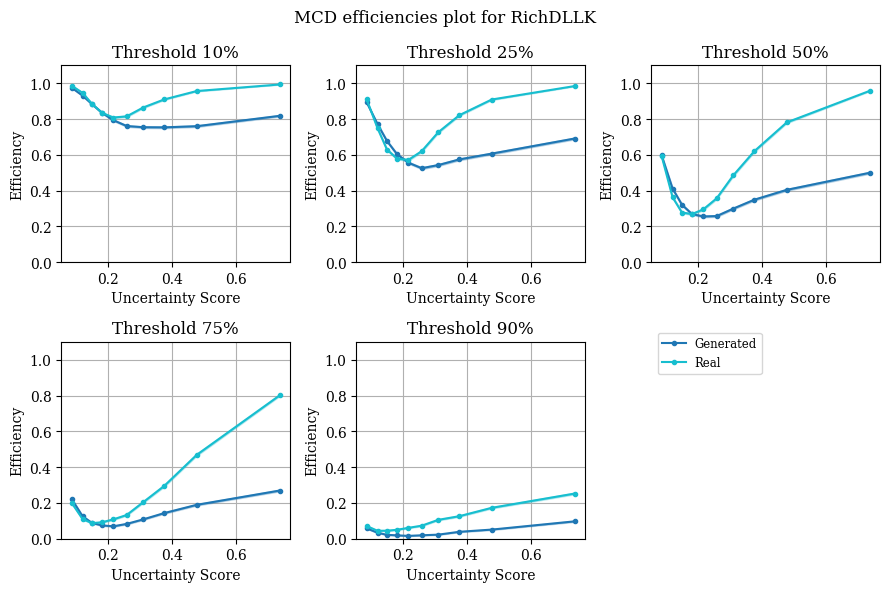

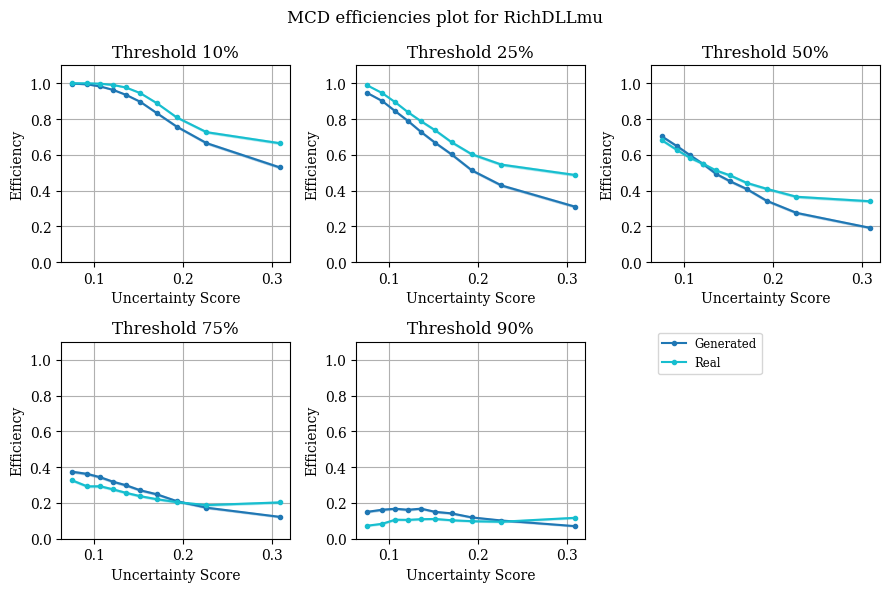

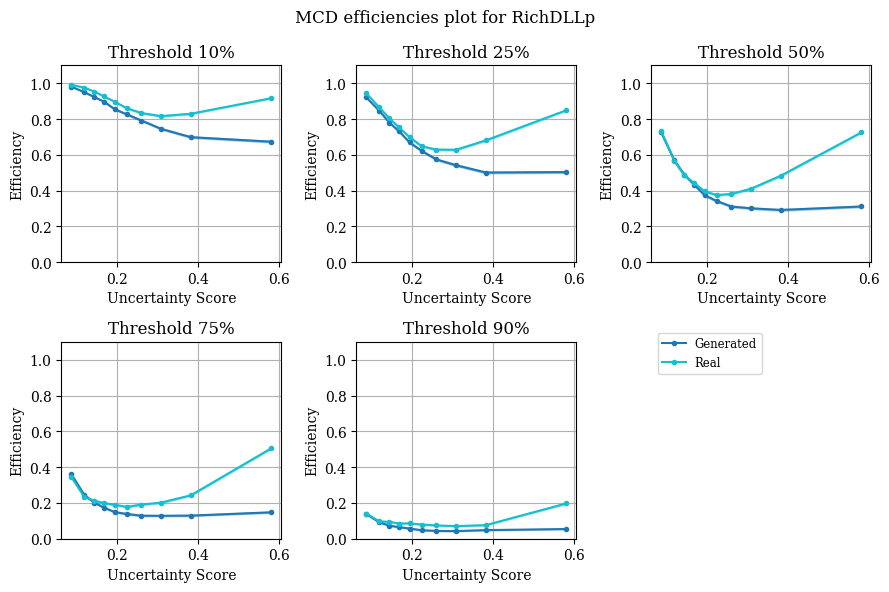

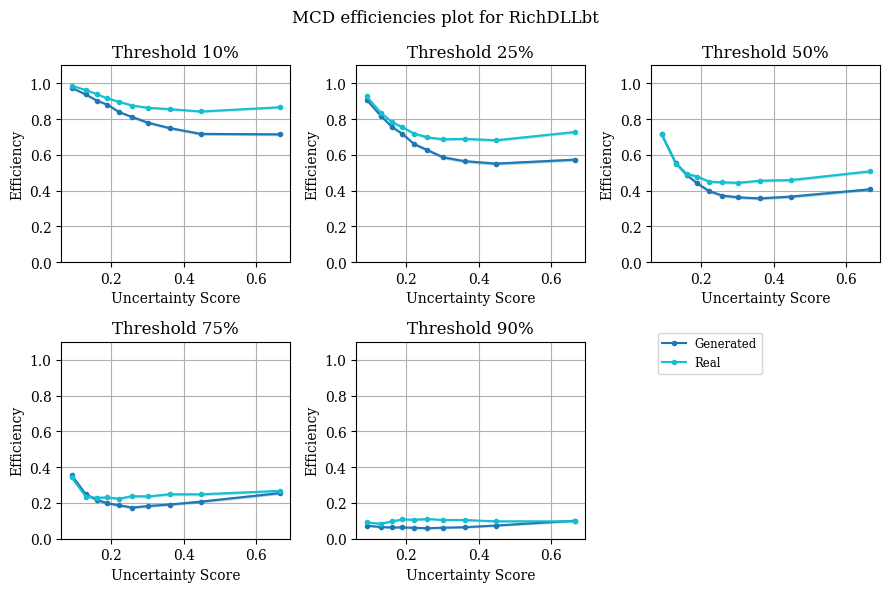

In [47]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, mcd_final_uncertainty, [.1, .25, .5, .75, .9], "MCD", i)